<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99_wrapup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Summary
---

tba

## Prerequisites
---

### Installation (if needed)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
IN_COLAB

False

In [2]:
if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

In [3]:
!python --version
# 3.9.* or 3.10.* work fine.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [4]:
if IN_COLAB: 
  !pip install -q tensorflow-federated==0.56.0
  #!pip install -r requirements.txt

In [5]:
!pip list | grep tensorflow
# for more details use !pip show tensorflow
#>tensorflow                    2.12.0
#>tensorflow-compression        2.12.0
#>tensorflow-datasets           4.8.3
#>tensorflow-estimator          2.12.0
#>tensorflow-federated          0.56.0
#>tensorflow-gcs-config         2.12.0
#>tensorflow-hub                0.13.0
#>tensorflow-io-gcs-filesystem  0.32.0
#>tensorflow-metadata           1.13.1
#>tensorflow-model-optimization 0.7.3
#>tensorflow-privacy            0.8.8
#>tensorflow-probability        0.15.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/env-tff/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-addons             0.20.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [6]:
# Save the package versioning to requirements.txt if needed (ovewrites the previous)
#!conda list --export > ../requirements.txt
# or
#!pip freeze > ../requirements.txt

### Imports
---

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress tf logging

#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

import pandas as pd
import numpy as np
import os
import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import product
from math import floor
import time

import tensorflow as tf
import tensorflow_federated as tff
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import CSVLogger

# -> check tff
#print(tff.federated_computation(lambda: 'Hello World')()) 

### Ingest data
---

In [8]:
df_locs = [
    '../output/data/insurance-clean.csv',
    "https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv"
]

def load_df(df_locs):
    """ Loads data from a path to a csv-file.
    
    :param df_locs: possible locations of a CSV file
    :type df_locs: str or list of str
    :output: Ingested Data.
    :rtype: pandas.DataFrame 
    """
    df = pd.DataFrame()

    if isinstance(df_locs, str): df_locs = [df_locs]
    
    for df_loc in df_locs:
        try:
            df = pd.read_csv(df_loc, index_col = 0)
            print("loaded data from {}".format(df_loc))
            if len(df) != 0: break
        except Exception as ex:
            print("{} in ".format(type(ex).__name__), df_loc)

    return df

df = load_df(df_locs)
df.head()

loaded data from ../output/data/insurance-clean.csv


,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


##### Select feature and target

In [9]:
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

##### Evaluation splits

In [10]:
nfolds = 5
nreps = 10

cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

ind = 0
for train, test in cv.split(df, df.region):
  
  label = 'rep' + str(floor(ind / nfolds)) + '-fold' + str(ind % nfolds)
  df.loc[train, label] = 'train'
  df.loc[test,  label] = 'test'
  ind += 1

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region0', 'region1', 'region2', 'region3', 'rep0-fold0', 'rep0-fold1',
       'rep0-fold2', 'rep0-fold3', 'rep0-fold4', 'rep1-fold0', 'rep1-fold1',
       'rep1-fold2', 'rep1-fold3', 'rep1-fold4', 'rep2-fold0', 'rep2-fold1',
       'rep2-fold2', 'rep2-fold3', 'rep2-fold4', 'rep3-fold0', 'rep3-fold1',
       'rep3-fold2', 'rep3-fold3', 'rep3-fold4', 'rep4-fold0', 'rep4-fold1',
       'rep4-fold2', 'rep4-fold3', 'rep4-fold4', 'rep5-fold0', 'rep5-fold1',
       'rep5-fold2', 'rep5-fold3', 'rep5-fold4', 'rep6-fold0', 'rep6-fold1',
       'rep6-fold2', 'rep6-fold3', 'rep6-fold4', 'rep7-fold0', 'rep7-fold1',
       'rep7-fold2', 'rep7-fold3', 'rep7-fold4', 'rep8-fold0', 'rep8-fold1',
       'rep8-fold2', 'rep8-fold3', 'rep8-fold4', 'rep9-fold0', 'rep9-fold1',
       'rep9-fold2', 'rep9-fold3', 'rep9-fold4'],
      dtype='object')

In [11]:
def select_split(
      df, 
      target = target, 
      features = features, 
      type = 'train', 
      rep = 0, 
      fold = 0
      ):
   """selects the train and test set from a specific column.

  Parameters
  ------------
  df: dataFrame
  target: str
  features: list of str
  type: str
      'train' or 'test'.
  rep, fold: int
      Considered is a repeated cross validation with ``rep`` repetions and ``fold`` folds.
  """
   
   labels = 'rep' + str(rep) + '-fold' + str(fold)
   
   X = df.loc[df[labels] == type, features]
   y = df.loc[df[labels] == type, target]
   
   return X, y

In [12]:
# test
X_train, y_train = select_split(df,
   features = features + ['rep' + str(1) + '-fold' + str(0)],
   type = 'train', rep = 1, fold = 0
   )
X_test, y_test = select_split(df,
   features = features + ['rep' + str(0) + '-fold' + str(0)],
   type = 'test', rep = 0, fold = 0
   )
print("====== Train ======")
print(X_train.head())
print("\n====== Test ======")
print(X_test.head())

del X_train, y_train, X_test, y_test

====== Train ======
        age  sex       bmi  children  smoker  region0  region1  region2  \
1  0.000000  1.0  0.479150       0.2     0.0      0.0      0.0      1.0   
2  0.217391  1.0  0.458434       0.6     0.0      0.0      0.0      1.0   
3  0.326087  1.0  0.181464       0.0     0.0      0.0      1.0      0.0   
5  0.282609  0.0  0.263115       0.0     0.0      0.0      0.0      1.0   
6  0.608696  0.0  0.470272       0.2     0.0      0.0      0.0      1.0   

   region3 rep1-fold0  
1      0.0      train  
2      0.0      train  
3      0.0      train  
5      0.0      train  
6      0.0      train  

====== Test ======
         age  sex       bmi  children  smoker  region0  region1  region2  \
8   0.413043  1.0  0.373150       0.4     0.0      1.0      0.0      0.0   
18  0.826087  1.0  0.654829       0.0     0.0      0.0      0.0      0.0   
25  0.891304  0.0  0.316384       0.6     0.0      0.0      0.0      1.0   
27  0.804348  0.0  0.452381       0.4     0.0      0.0      1

### Model wrapper
---

In [13]:
def build_model(
    nfeatures = 9,
    units = [40, 40, 20], 
    activations = ['relu'] * 3, 
    compile = True,
    loss = 'mean_squared_error',
    optimizer = tf.optimizers.legacy.Adam(learning_rate = .05),
    metrics = ["mae", 'mean_squared_error', r2_score], 
    run_eagerly = True
    ):
  
  """Construct a fully connected neural network and compile it.
  
  Parameters
  ------------
  nfeatures: int, optional
    Number of input features. Default is 9.
  units: list of int, optional
    List of number of units of the hidden dense layers. The length of ``units`` defines the number of hidden layers. Default are 3 layers with 40, 40 an 20 units, respectively.
  activations: list of str, optional
    List of activation functions used in the hidden layers.
  loss: str, optional
    Used loss function for compiling.
  optimizer: keras.optimizers, optional
    Used optimizer for compiling.
  metrics: list of str or sklearn.metrics
    List of metrics for compiling.
  run_eagerly: bool
    Parameter for compiling

  Return
  ------------
    model: keras.engine.sequential.Sequential
      Keras sequential fully connected neural network. Already compiled.
  """
  
  # construct model
  model = Sequential()
  model.add(InputLayer(input_shape = [nfeatures]))
  for ind in range(len(units)):
    model.add(Dense(
      units = units[ind], 
      activation = activations[ind]
      ))
  model.add(Dense(1))
  
  # compile model
  if compile:
    model.compile(
      loss = loss,
      optimizer = optimizer,
      metrics = metrics,
      run_eagerly = run_eagerly
    )

  return model

build_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
def train_model(model, X_train, y_train,
    epochs           = 100,
    batch_size       = 128,
    shuffle          = True,
    validation_split = 0.2,
    verbose          = 0,
    output_msr       = 'loss',
    seed             = 42,
    **kwargs
    ):
  
  """Compile and train a Keras neural network.
  
  For additional arguments see https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit.

  Parameters
  ------------
  model: keras.engine.sequential.Sequential
  X_train: dataFrame
  y_train: dataFrame
  shuffle: bool
  epochs: int
  validation_split: float
  verbose: int
    verbose of model.fit(...)
  output_msr: str
    measure for custom output.
  batch_size: int
    batch_size of model.fit(...)   

  Return
  ------------
    hist: keras.callbacks.History
      History of model.fit(...)
  """

  # fit with custom verbose
  starttime = time.time()
  
  if seed != None: tf.keras.utils.set_random_seed(seed)

  hist = model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    shuffle    = shuffle,
    validation_split = validation_split,
    epochs     = epochs,
    verbose    = verbose, 
    **kwargs
  )
  print(
      "R^2  = %.4f, " % hist.history[output_msr][-1],
      "time = %.1f sec" % ((time.time() - starttime)))
  
  return hist

In [15]:
def test_model(model, X_test, y_test, 
               verbose = False):
  """
  Parameters
  ------------
  model: keras.engine.sequential.Sequential
    Fitted model.
  X_test, y_test: dataFrame
    Test data.
  verbose: bool
    Output control.

  Output
  ------------
  perf: list of float
    The test performances.
  """

  start = time.time() 
  perf  = model.evaluate(X_test, y_test, verbose = 0)[1:]

  if verbose: print('time - test: %.2f' % (time.time() - start / 60))
  
  return perf

In [16]:
def plot_perf(hist, msr = 'loss'):
  """Plot the training history and save the figure.
  :param hist: The history object including the metrics to plot
  :type hist: keras.callbacks.History
  :param msr: The metrics to plot
  :type msr: str, optional
  """
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')

## Experiments
---

In [17]:
# logging path
log_path = '../output/experiments' 

### Centralized Model
---

In [18]:
experiment_name = '00_central'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

#### Training

In [19]:
%%time

n_epochs = 100

hists = []
for rep, fold in list(product(range(nreps), range(nfolds)))[:]:
    
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))
    
    model            = build_model()
    X_train, y_train = select_split(df, type = 'train', rep = rep, fold = fold)
    
    hist             = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")],
        seed = 42
        )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    hists.append(hist)


======= rep 0 - fold 0  =======
R^2  = 0.8431,  time = 42.3 sec
======= rep 0 - fold 1  =======
R^2  = 0.8660,  time = 38.7 sec
======= rep 0 - fold 2  =======
R^2  = 0.8589,  time = 41.5 sec
======= rep 0 - fold 3  =======
R^2  = 0.8361,  time = 39.9 sec
======= rep 0 - fold 4  =======
R^2  = 0.8438,  time = 38.5 sec
======= rep 1 - fold 0  =======
R^2  = 0.8467,  time = 41.0 sec
======= rep 1 - fold 1  =======
R^2  = 0.8408,  time = 39.0 sec
======= rep 1 - fold 2  =======
R^2  = 0.8722,  time = 38.0 sec
======= rep 1 - fold 3  =======
R^2  = 0.8442,  time = 38.0 sec
======= rep 1 - fold 4  =======
R^2  = 0.8372,  time = 38.0 sec
======= rep 2 - fold 0  =======
R^2  = 0.8481,  time = 37.9 sec
======= rep 2 - fold 1  =======
R^2  = 0.8509,  time = 38.7 sec
======= rep 2 - fold 2  =======
R^2  = 0.8428,  time = 40.0 sec
======= rep 2 - fold 3  =======
R^2  = 0.8471,  time = 40.0 sec
======= rep 2 - fold 4  =======
R^2  = 0.8591,  time = 41.0 sec
======= rep 3 - fold 0  =======
R^2  = 0

#### Evaluation

In [39]:
range(len(hists))

range(0, 50)

In [41]:
# calculate the performance
perfs = []


for i in range(len(hists)):
  
  rep  = int(i / nfolds)
  fold = int(i % nfolds)

  model          = hists[i].model
  X_test, y_test = select_split(df, type = 'test', rep = rep, fold = fold)
  perfs.append([rep, fold] + test_model(model, X_test, y_test))



# convert to DataFrame
perfs = pd.DataFrame(perfs, columns = ["rep", "fold","MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)

##### Tables

**Overview**

In [42]:
res = perfs[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)
res.to_csv(experiment_path + "results/performance_test_overview.csv", sep = ";")
res

,MAE,RMSE,RSQ_pct
mean,2974.64,4906.89,81.20
std,284.07,379.93,3.71
min,2415.64,4076.45,74.33
25%,2765.14,4603.44,78.39
50%,2950.75,4903.06,81.75
75%,3146.59,5191.81,84.19
max,3581.20,5722.28,88.78


**All Evaluations**

In [43]:
res_all = perfs[["rep", "fold",'MAE', 'RMSE', 'RSQ_pct']].sort_values('RSQ_pct').round(2)

res_all.to_csv(experiment_path + "results/performance_all_evals.csv", sep = ";")

##### Investigation

In [46]:

results = []


#i = 0
for i in range(len(hists)):
  
    rep  = int(i / nreps)
    fold = i % nfolds

    results.append(
        [rep, fold] + [
            hists[i].history['r2_score'][-1],
            float(perfs[(perfs.rep ==rep) & (perfs.fold==fold)]["RSQ"]), 
            hists[i].history['val_r2_score'][-1], 
            
             hists[i].history['r2_score'][-1] /  float(perfs[(perfs.rep ==rep) & (perfs.fold==fold)]["RSQ"])- 1
            ] +
         [x - 1 for x in 
         list(df.loc[df['rep'+str(rep)+'-fold'+str(fold)] == 'test', features[:5] + [target]].mean() /
         df.loc[df['rep'+str(rep)+'-fold'+str(fold)] == 'train', features[:5] + [target]].mean())]
    )


results = pd.DataFrame(
    results
    , columns = ['rep', 'fold', "RSQ_train",'RSQ_test', "RSQ_eval",  "pct_diff_tt"]+['mean_ttdiff_' + x for x in features[:5] + [target]]
    )

#results.sort_values("pct_diff_tt")

# save all perfomances
# pd.DataFrame(hists[0].history).iloc[-1]

results.to_csv(experiment_path + "results/performance_details.csv", sep = ";")
results

,rep,fold,RSQ_train,RSQ_test,RSQ_eval,pct_diff_tt,mean_ttdiff_age,mean_ttdiff_sex,mean_ttdiff_bmi,mean_ttdiff_children,mean_ttdiff_smoker,mean_ttdiff_charges
0,0,0,0.843104,0.824696,0.807754,0.022321,0.023546,0.024108,-0.000275,-0.006120,0.317925,0.149049
1,0,1,0.865952,0.758861,0.849169,0.141122,-0.037663,-0.022086,-0.058967,-0.048271,0.002692,-0.037433
2,0,2,0.858947,0.849606,0.844639,0.010994,-0.082120,0.109457,0.039859,0.028121,-0.173351,-0.102802
3,0,3,0.836059,0.845066,0.826699,-0.010658,0.084521,-0.063069,0.025432,-0.001466,0.100758,0.063132
4,0,4,0.843831,0.785901,0.850021,0.073710,0.015209,-0.044944,-0.004838,0.028610,-0.211766,-0.063584
5,0,0,0.846736,0.824696,0.817401,0.026725,0.023546,0.024108,-0.000275,-0.006120,0.317925,0.149049
6,0,1,0.840776,0.758861,0.843179,0.107945,-0.037663,-0.022086,-0.058967,-0.048271,0.002692,-0.037433
7,0,2,0.872248,0.849606,0.877983,0.026650,-0.082120,0.109457,0.039859,0.028121,-0.173351,-0.102802
8,0,3,0.844182,0.845066,0.809131,-0.001047,0.084521,-0.063069,0.025432,-0.001466,0.100758,0.063132
9,0,4,0.837222,0.785901,0.836102,0.065301,0.015209,-0.044944,-0.004838,0.028610,-0.211766,-0.063584


##### Plots

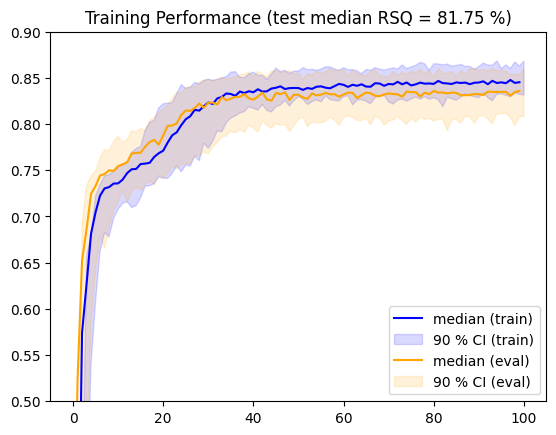

<Figure size 640x480 with 0 Axes>

In [48]:
y1 = np.array([hist.history["r2_score"] for hist in hists])
y2 = np.array([hist.history["val_r2_score"] for hist in hists])

plt.plot(np.quantile(y1,.5, axis = 0), label = 'median (train)', color = 'blue')
plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.05, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.15, label = '90 % CI (train)')
plt.plot(np.quantile(y2,.5, axis = 0), label = 'median (eval)', color = 'orange')
plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.05, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.15, label = '90 % CI (eval)')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2))+ " %)")

plt.legend()
plt.ylim([0.5, 0.9])
plt.show()
plt.savefig(experiment_path + 'results/training_performance_confidence.png')

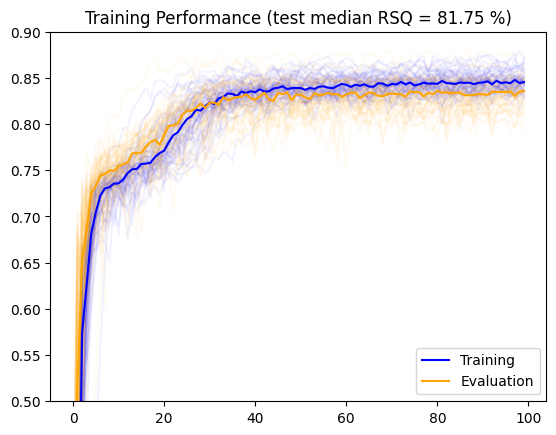

<Figure size 640x480 with 0 Axes>

In [55]:

y1 = np.array([hist.history["r2_score"] for hist in hists])
y2 = np.array([hist.history["val_r2_score"] for hist in hists])

plt.plot(y1.transpose(), color = 'blue', alpha = .05)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.1, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.05, label = '90 % CI (train)')
plt.plot(y2.transpose(), color = 'orange', alpha = .05)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.6, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.05, label = '90 % CI (eval)')
plt.plot(np.quantile(y1,.5, axis = 0), label = 'Training', color = 'blue')
plt.plot(np.quantile(y2,.5, axis = 0), label = 'Evaluation', color = 'orange')


#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2)) + " %)")

plt.legend()
plt.ylim([0.5, 0.9])
plt.show()
plt.savefig(experiment_path + 'results/training_performance.png')

In [ ]:
# All plots (if needed)
if False:
    for i in range(len(hists)):
  
        rep  = int(i / nreps)
        fold = i % nfolds
        
        plot_perf(hists[i], 'r2_score')
        #plt.suptitle('Training Performance (test r2_score = ' + str(round(perfs[ind][2] * 100, 2))+ " %)")
        #'Training Performance (test r2_score = ' + str(round(perfs[ind][2] * 100, 2))+ " %)")
        plt.suptitle('Training Performance for rep = ' + str(rep) + ', fold = ' + str(fold))
        plt.title(' (test RSQ = ' + str(round(perfs.loc[i,'RSQ_pct'], 2))+ " %)")
        plt.ylim([0.5, 0.9])
        plt.show()


### Centralized (5 Features)

In [60]:
experiment_name = '01_central5'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

In [61]:
%%time

n_epochs = 100

hists = []
for rep, fold in product(range(nreps), range(nfolds)):
    
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))
    
    model          = build_model(nfeatures = 5)
    X_train, y_train = select_split(df, features = features[:5], type = 'test', rep = rep, fold = fold)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
        )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    hists.append(hist)

======= rep 0 - fold 0  =======
R^2  = 0.7435,  time = 19.8 sec
======= rep 0 - fold 1  =======
R^2  = 0.7267,  time = 17.4 sec
======= rep 0 - fold 2  =======
R^2  = 0.7814,  time = 17.2 sec
======= rep 0 - fold 3  =======
R^2  = 0.8135,  time = 17.4 sec
======= rep 0 - fold 4  =======
R^2  = 0.7186,  time = 17.0 sec
======= rep 1 - fold 0  =======
R^2  = 0.8321,  time = 16.7 sec
======= rep 1 - fold 1  =======
R^2  = 0.7909,  time = 16.8 sec
======= rep 1 - fold 2  =======
R^2  = 0.6818,  time = 16.4 sec
======= rep 1 - fold 3  =======
R^2  = 0.7947,  time = 16.3 sec
======= rep 1 - fold 4  =======
R^2  = 0.8394,  time = 16.0 sec
======= rep 2 - fold 0  =======
R^2  = 0.7990,  time = 16.0 sec
======= rep 2 - fold 1  =======
R^2  = 0.7440,  time = 15.8 sec
======= rep 2 - fold 2  =======
R^2  = 0.7894,  time = 16.0 sec
======= rep 2 - fold 3  =======
R^2  = 0.7523,  time = 15.6 sec
======= rep 2 - fold 4  =======
R^2  = 0.7644,  time = 15.4 sec
======= rep 3 - fold 0  =======
R^2  = 0

In [62]:
# calculate the performance
perfs = [None] * nreps * nfolds

i = 0
for rep, fold in product(range(nreps), range(nfolds)):
  
  model          = hists[i].model
  X_test, y_test = select_split(df, features = features[:5], type = 'test', rep = rep, fold = fold)
  perfs[i]       = [rep, fold] + test_model(model, X_test, y_test)

  i += 1

# convert to DataFrame
perfs = pd.DataFrame(perfs, columns = ["rep", "fold","MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)

res = perfs[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)
res.to_csv(experiment_path + "results/test_performance_overview.csv", sep = ";")
res 

,MAE,RMSE,RSQ_pct
mean,3842.93,5729.68,74.09
std,438.47,469.66,5.30
min,2204.34,4156.01,64.08
25%,3616.57,5525.63,70.36
50%,3863.28,5784.54,73.79
75%,4068.17,5967.48,77.37
max,4603.45,6842.29,86.89


In [ ]:
res_all = perfs[["rep", "fold",'MAE', 'RMSE', 'RSQ_pct']].sort_values('RSQ_pct').round(2)
res_all.to_csv(experiment_path + "results/performance_all_evals.csv", sep = ";")

In [63]:

results = []

i = 0
for i in range(len(hists)):
  
    rep  = int(i / nreps)
    fold = i % nfolds

    results.append(
        [rep, fold]+ [
            hists[i].history['r2_score'][-1],
            float(perfs[(perfs.rep ==rep) & (perfs.fold==fold)]["RSQ"]), 
            hists[i].history['val_r2_score'][-1], 
            
             hists[i].history['r2_score'][-1] /  float(perfs[(perfs.rep ==rep) & (perfs.fold==fold)]["RSQ"])- 1
            ] +
        [x - 1 for x in 
        list(df.loc[df['rep'+str(rep)+'-fold'+str(fold)] == 'test', features[:5] + [target]].mean() /
        df.loc[df['rep'+str(rep)+'-fold'+str(fold)] == 'train', features[:5] + [target]].mean())])


results = pd.DataFrame(
    results, 
    columns = ['rep', 'fold', "RSQ_train",'RSQ_test', "RSQ_eval",  "pct_diff_tt"]+['mean_ttdiff_' + x for x in features[:5] + [target]]
    )

results.sort_values("pct_diff_tt")

# save all perfomances
# pd.DataFrame(hists[0].history).iloc[-1]

results.to_csv(experiment_path + "results/performance_details.csv", sep = ";")

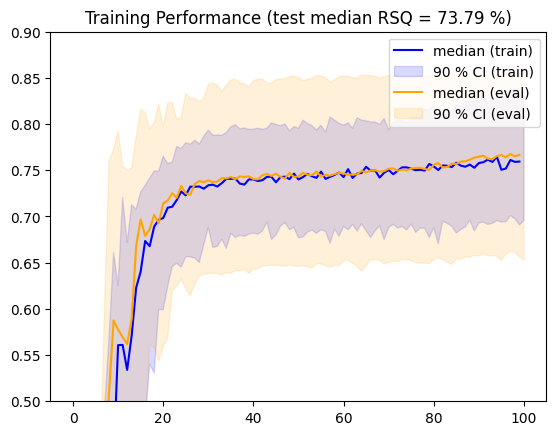

<Figure size 640x480 with 0 Axes>

In [64]:
y1 = np.array([hist.history["r2_score"] for hist in hists])
y2 = np.array([hist.history["val_r2_score"] for hist in hists])

plt.plot(np.quantile(y1,.5, axis = 0), label = 'median (train)', color = 'blue')
plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.05, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.15, label = '90 % CI (train)')
plt.plot(np.quantile(y2,.5, axis = 0), label = 'median (eval)', color = 'orange')
plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.05, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.15, label = '90 % CI (eval)')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2))+ " %)")

plt.legend()
plt.ylim([0.5, 0.9])
plt.show()
plt.savefig(experiment_path + 'results/training_performance.png')

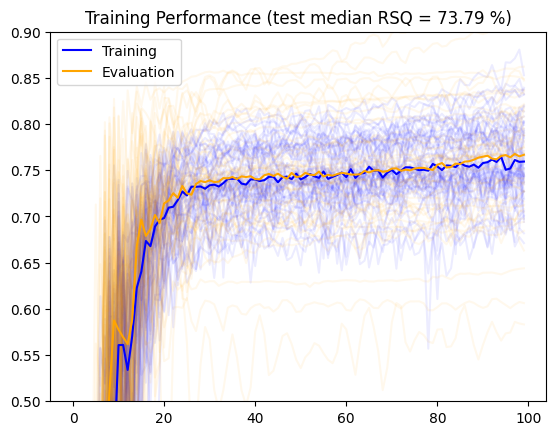

<Figure size 640x480 with 0 Axes>

In [66]:

y1 = np.array([hist.history["r2_score"] for hist in hists])
y2 = np.array([hist.history["val_r2_score"] for hist in hists])

plt.plot(y1.transpose(), color = 'blue', alpha = .075)
#plt.fill_between(range(1, n_epochs + 1 ), np.quantile(y1,.05, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.1, label = '90 % CI (train)')
plt.plot(y2.transpose(), color = 'orange', alpha = .075)
plt.plot(np.quantile(y1,.5, axis = 0), label = 'Training', color = 'blue')

plt.plot(np.quantile(y2,.5, axis = 0), label = 'Evaluation', color = 'orange')
#plt.fill_between(range(1, n_epochs + 1), np.quantile(y2,.05, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.1, label = '90 % CI (eval)')


#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2))+ " %)")

plt.legend()
plt.ylim([0.5, 0.9])
plt.show()
plt.savefig(experiment_path + 'results/training_performance.png')

### Centralized Tuning
---

Is the centralized model improvable?

- train_model(..., steps_per_epoch = 3) -> improves the result?
- FIXME: What about random forests?
- FIXME: Systematic tuning